Neural Network for CIFAR-10 Image Classification

This project involves implementing a neural network to classify images from the CIFAR-10 dataset. Our approach uses a specific architecture described in the assignment, incorporating multiple intermediate blocks and an output block.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.multiprocessing as mp
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

Task 1: Dataset Preparation

We start by loading the CIFAR-10 dataset and preparing DataLoaders for both training and testing datasets. This enables efficient batch processing during model training and evaluation.

In [2]:
#Transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)


testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)




Files already downloaded and verified
Files already downloaded and verified


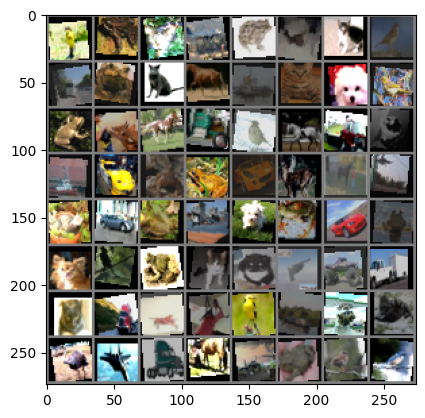

bird frog cat plane frog cat cat bird truck frog cat horse ship cat dog bird frog deer horse truck bird horse truck cat ship car frog frog car deer horse plane cat car frog ship dog frog car frog dog bird frog cat cat plane truck truck cat truck plane plane bird ship plane cat bird plane truck horse plane frog bird bird


In [3]:
#Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize the images
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#To get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

#Classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#Showing images
imshow(torchvision.utils.make_grid(images))


print(' '.join(f'{classes[labels[j]]}' for j in range(len(labels))))

Task 2: Basic Neural Network Architecture

Following the assignment's guidelines, we construct the neural network architecture. This section outlines the creation of intermediate blocks and the output block, detailing the convolutional layers and the mechanism for combining their outputs.

In [4]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers):
        super(IntermediateBlock, self).__init__()
        self.conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2)
            ) for i in range(num_layers)
        ])

    def forward(self, x):
        conv_outputs = [conv(x) for conv in self.conv_layers]
        avg_values = self.avg_pool(x).view(x.shape[0], -1)
        coefficients = F.softmax(self.fc(avg_values), dim=1)

        #Initializing a tensor for accumulating the weighted sum of conv layer outputs
        combined = torch.zeros_like(conv_outputs[0]).to(x.device)  # Ensure it's on the right device
        for i in range(len(conv_outputs)):
            #Adjusting coefficients for broadcasting and ensuring compatibility
            scale_factor = coefficients[:, i].view(-1, 1, 1, 1)
            scaled_output = scale_factor * conv_outputs[i]  
            combined += scaled_output

        return combined



class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()

        #Intermediate Block 1
        self.conv1 = nn.Conv2d(3, 6, 5)  
        self.pool = nn.MaxPool2d(2, 2)
        #Intermediate Block 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        #Output block
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



Task 3: Training and Testing

Here, we describe our approach to training the neural network on the CIFAR-10 training dataset and evaluating its performance on the testing dataset. Cross-entropy loss is used for optimization

Model Training
We detail the training procedure, including hyperparameter settings and the training loop..

In [5]:
#Function to calculate accuracy
def calculate_accuracy(y_pred, y_true):
    predicted = torch.argmax(y_pred, 1)
    correct = (predicted == y_true).float().sum()
    return correct / y_true.shape[0]

#Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += calculate_accuracy(outputs, labels)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_accuracy / len(train_loader)
    return epoch_loss, epoch_accuracy

#Validation function
def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            running_accuracy += calculate_accuracy(outputs, labels)

    epoch_loss = running_loss / len(test_loader)
    epoch_accuracy = running_accuracy / len(test_loader)
    return epoch_loss, epoch_accuracy


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = BasicCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Number of epochs
num_epochs = 20  # You can adjust this as needed

# Lists for storing training and validation loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
batch_losses = []

# Training loop
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}/{num_epochs}")
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    print(f"Completed training for epoch {epoch+1}/{num_epochs}")
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)
    print(f"Completed validation for epoch {epoch+1}/{num_epochs}")
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')



Using device: cuda
Starting epoch 1/20


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Completed training for epoch 1/20
Completed validation for epoch 1/20
Epoch 1/20 - Train Loss: 2.3011, Train Acc: 0.1066, Val Loss: 2.2946, Val Acc: 0.1219
Starting epoch 2/20
Completed training for epoch 2/20
Completed validation for epoch 2/20
Epoch 2/20 - Train Loss: 2.0706, Train Acc: 0.2321, Val Loss: 1.9365, Val Acc: 0.3027
Starting epoch 3/20
Completed training for epoch 3/20
Completed validation for epoch 3/20
Epoch 3/20 - Train Loss: 1.8428, Train Acc: 0.3205, Val Loss: 1.6800, Val Acc: 0.3810
Starting epoch 4/20
Completed training for epoch 4/20
Completed validation for epoch 4/20
Epoch 4/20 - Train Loss: 1.7348, Train Acc: 0.3643, Val Loss: 1.5887, Val Acc: 0.4166
Starting epoch 5/20
Completed training for epoch 5/20
Completed validation for epoch 5/20
Epoch 5/20 - Train Loss: 1.6673, Train Acc: 0.3931, Val Loss: 1.5324, Val Acc: 0.4416
Starting epoch 6/20
Completed training for epoch 6/20
Completed validation for epoch 6/20
Epoch 6/20 - Train Loss: 1.6202, Train Acc: 0.4171

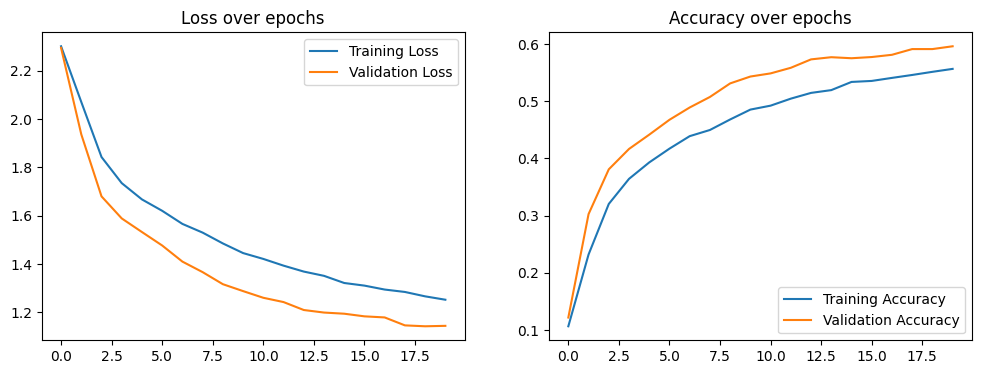

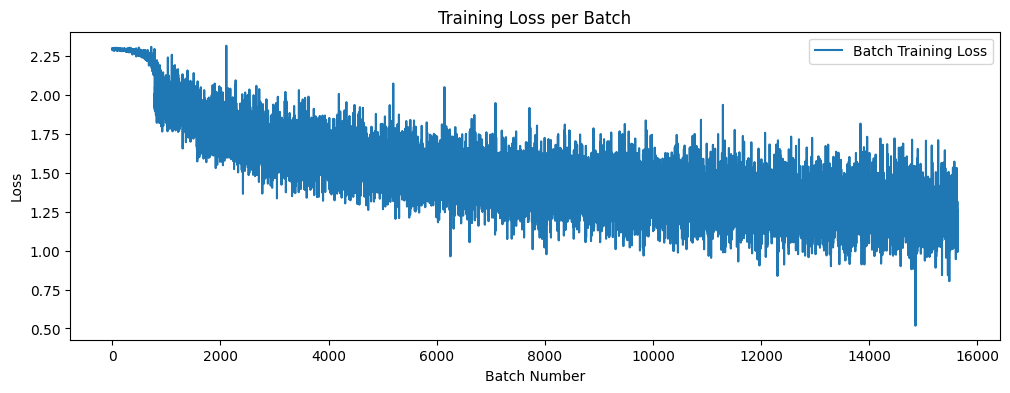

In [7]:
#Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

#Plot training and validation accuracy
#Converting lists of tensors to lists of numpy arrays
train_accuracies_np = [acc.cpu().numpy() for acc in train_accuracies]
val_accuracies_np = [acc.cpu().numpy() for acc in val_accuracies]

#Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_np, label='Training Accuracy')
plt.plot(val_accuracies_np, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

# Plot batch training loss
plt.figure(figsize=(12, 4))
plt.plot(batch_losses, label='Batch Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.legend()


plt.show()


In [8]:
# # Saving the Model

# # Define the path where you want to save the model
# model_path = './cifar10_classifier_basic.pth'

# # Save the model's state dictionary
# torch.save(model.state_dict(), model_path)

# print(f'Model saved to {model_path}')


In [9]:
# Calculate the final training and validation accuracy
final_train_accuracy = train_accuracies[-1] * 100  # Converting to percentage
final_val_accuracy = val_accuracies[-1] * 100  # Converting to percentage
# Calculate the average batch training loss
average_batch_loss = sum(batch_losses) / len(batch_losses)

# Print the final accuracies
print(f'The final training accuracy is: {final_train_accuracy:.2f}%')
print(f'The final validation accuracy is: {final_val_accuracy:.2f}%')
# Print the average batch training loss
# print(f'Average Batch Training Loss: {average_batch_loss:.4f}')

The final training accuracy is: 55.66%
The final validation accuracy is: 59.61%


Task 4: Advanced/ Custom Neural Network Architecture


In [10]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers):
        super(IntermediateBlock, self).__init__()
        self.conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2)
            ) for i in range(num_layers)
        ])

    def forward(self, x):
        conv_outputs = [conv(x) for conv in self.conv_layers]
        avg_values = self.avg_pool(x).view(x.shape[0], -1)
        coefficients = F.softmax(self.fc(avg_values), dim=1)

        #Initializing a tensor for accumulating the weighted sum of conv layer outputs
        combined = torch.zeros_like(conv_outputs[0]).to(x.device)  
        for i in range(len(conv_outputs)):
            #Adjusting coefficients for broadcasting and ensuring compatibility
            scale_factor = coefficients[:, i].view(-1, 1, 1, 1)
            scaled_output = scale_factor * conv_outputs[i]  
            combined += scaled_output

        return combined


class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [11]:
#Function to calculate accuracy
def calculate_accuracy(y_pred, y_true):
    predicted = torch.argmax(y_pred, 1)
    correct = (predicted == y_true).float().sum()
    return correct / y_true.shape[0]

#Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += calculate_accuracy(outputs, labels)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_accuracy / len(train_loader)
    return epoch_loss, epoch_accuracy

#Validation function
def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            running_accuracy += calculate_accuracy(outputs, labels)

    epoch_loss = running_loss / len(test_loader)
    epoch_accuracy = running_accuracy / len(test_loader)
    return epoch_loss, epoch_accuracy


In [12]:
model = CustomCNN().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)




#Loss function 
criterion = nn.CrossEntropyLoss()

#Number of epochs
num_epochs = 90  

#Lists for storing training and validation loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
batch_losses = []

#Training loop
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}/{num_epochs}")
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    print(f"Completed training for epoch {epoch+1}/{num_epochs}")
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)
    print(f"Completed validation for epoch {epoch+1}/{num_epochs}")

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

Starting epoch 1/90
Completed training for epoch 1/90
Completed validation for epoch 1/90
Epoch 1/90 - Train Loss: 1.7224, Train Acc: 0.3638, Val Loss: 1.3846, Val Acc: 0.5119
Starting epoch 2/90
Completed training for epoch 2/90
Completed validation for epoch 2/90
Epoch 2/90 - Train Loss: 1.3321, Train Acc: 0.5228, Val Loss: 1.1027, Val Acc: 0.5867
Starting epoch 3/90
Completed training for epoch 3/90
Completed validation for epoch 3/90
Epoch 3/90 - Train Loss: 1.1878, Train Acc: 0.5807, Val Loss: 0.8777, Val Acc: 0.6916
Starting epoch 4/90
Completed training for epoch 4/90
Completed validation for epoch 4/90
Epoch 4/90 - Train Loss: 1.1056, Train Acc: 0.6141, Val Loss: 0.8532, Val Acc: 0.6963
Starting epoch 5/90
Completed training for epoch 5/90
Completed validation for epoch 5/90
Epoch 5/90 - Train Loss: 1.0333, Train Acc: 0.6383, Val Loss: 0.7416, Val Acc: 0.7409
Starting epoch 6/90
Completed training for epoch 6/90
Completed validation for epoch 6/90
Epoch 6/90 - Train Loss: 0.986

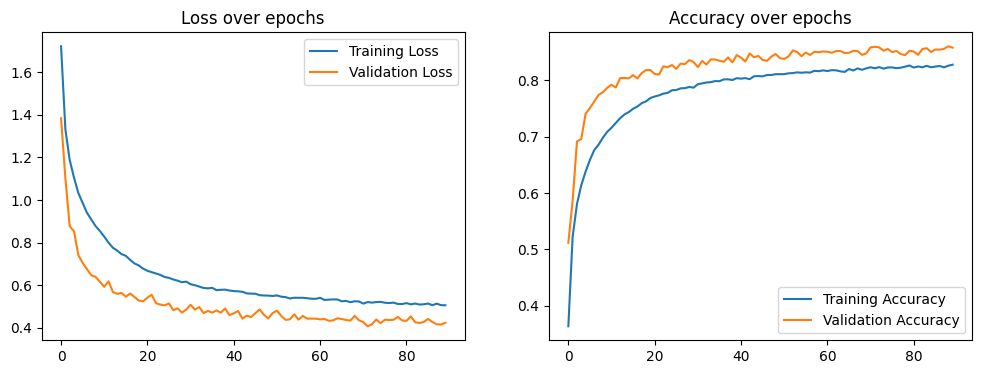

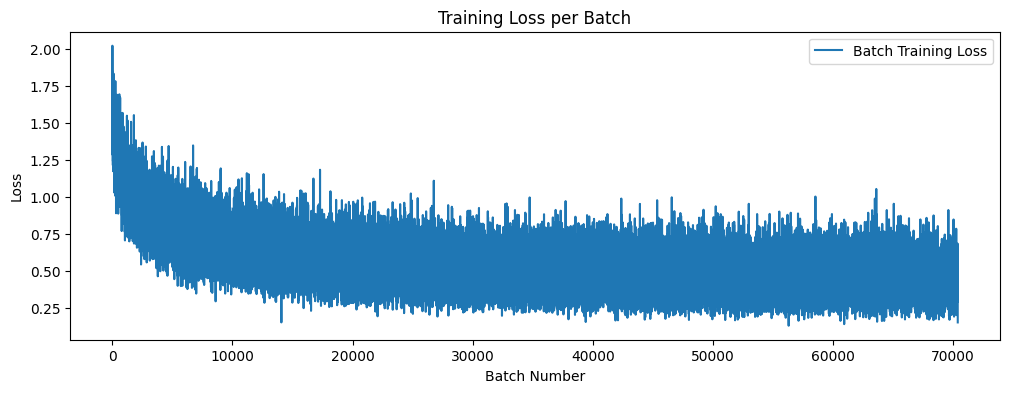

In [13]:
#Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

#Plot training and validation accuracy
#Converting lists of tensors to lists of numpy arrays
train_accuracies_np = [acc.cpu().numpy() for acc in train_accuracies]
val_accuracies_np = [acc.cpu().numpy() for acc in val_accuracies]

#Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_np, label='Training Accuracy')
plt.plot(val_accuracies_np, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

# Plot batch training loss
plt.figure(figsize=(12, 4))
plt.plot(batch_losses, label='Batch Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.legend()


plt.show()


In [14]:
# Saving the Model

# Define the path where you want to save the model
model_path = './cifar10_classifier_custom.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

print(f'Model saved to {model_path}')


Model saved to ./cifar10_classifier_custom.pth


In [15]:
# Calculate the final training and validation accuracy
final_train_accuracy = train_accuracies[-1] * 100  # Converting to percentage
final_val_accuracy = val_accuracies[-1] * 100  # Converting to percentage

# Print the final accuracies
print(f'The final training accuracy is: {final_train_accuracy:.2f}%')
print(f'The final validation accuracy is: {final_val_accuracy:.2f}%')

The final training accuracy is: 82.79%
The final validation accuracy is: 85.81%
